<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#KNeighborsRegressor" data-toc-modified-id="KNeighborsRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>KNeighborsRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
pip install -q --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

## Подготовка

In [3]:
taxi_df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0]) #загрузка данных
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
taxi_df.index.is_monotonic #проверка на монотонность индекса

True

In [5]:
taxi_df = taxi_df.resample('1H').sum() #ресемплирование по одному часу
taxi_df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод**

На этапе подготовки загрузили данные с нужным типом, проверили индекс на монотонность, выполнили ресемплирование данных по одному часу для дальнейшего анализа и обучения. 

## Анализ

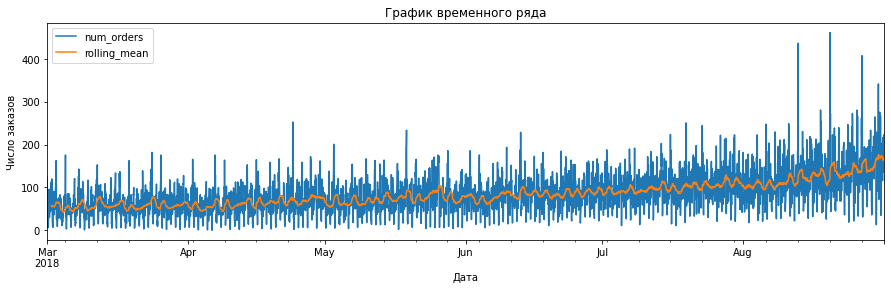

In [6]:
taxi_analysis = taxi_df.copy()
taxi_analysis['rolling_mean'] = taxi_analysis.rolling(24).mean()

taxi_analysis.plot(figsize=(15,4))
plt.title('График временного ряда')
plt.xlabel('Дата')
plt.ylabel('Число заказов')
plt.show()

In [7]:
decomposed = seasonal_decompose(taxi_df)

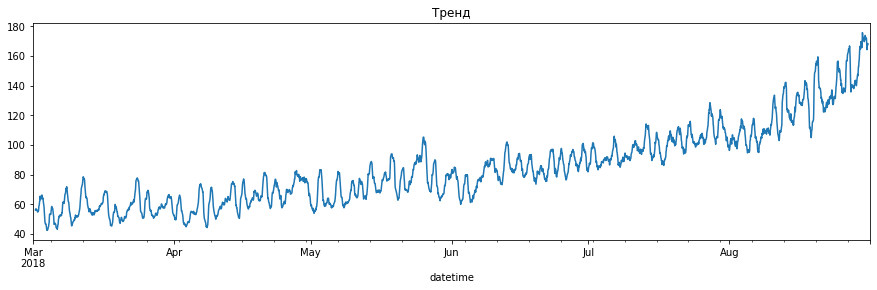

In [8]:
decomposed.trend.plot(figsize=(15,4))
plt.title('Тренд')
plt.show()

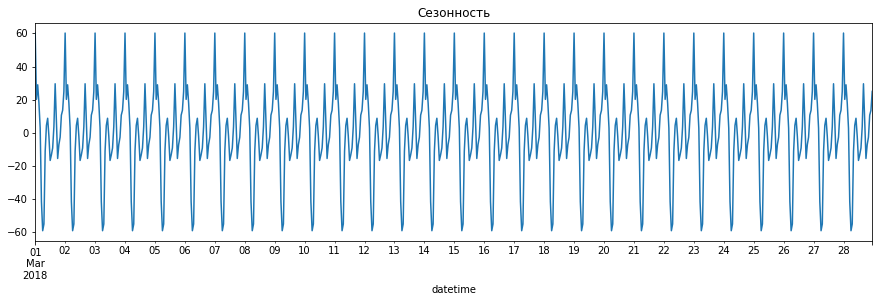

In [9]:
decomposed.seasonal.head(672).plot(figsize=(15,4))
plt.title('Сезонность')
plt.show()

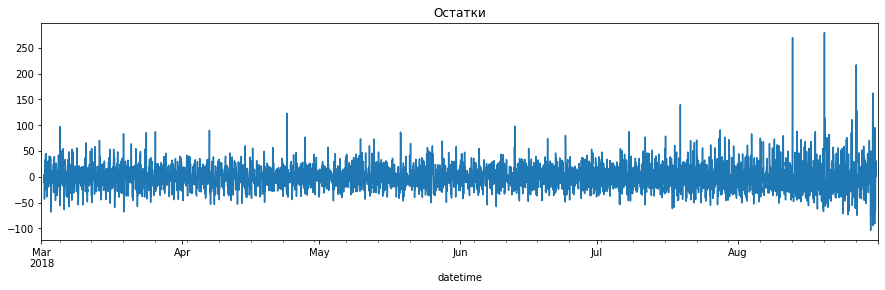

In [10]:
decomposed.resid.plot(figsize=(15,4))
plt.title('Остатки')
plt.show()

**Вывод**

На этапе анализа видим тренд роста количества заказов. Наблюдается дневная сезонность - ночью спад заказов, а вечером пик. В августе отмечается увеличение шума.

## Обучение

In [11]:
def make_features(data, max_lag, rolling_mean_size): #функиця создания новых признаков
    #data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek  
    #data['day'] = data.index.day
    data['hour'] = data.index.hour
    
    for lag in range(6, max_lag + 1, 6):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [12]:
taxi_ml = taxi_df.copy()
make_features(taxi_ml, 24, 24)
taxi_ml.head(25)

,num_orders,dayofweek,hour,lag_6,lag_12,lag_18,lag_24,rolling_mean
datetime,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,5,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,6,124.0,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,7,85.0,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,3,8,71.0,NaN,NaN,NaN,NaN


In [13]:
RANDOM_STATE = 42

taxi_ml = taxi_ml.dropna()

X = taxi_ml.drop('num_orders', axis=1)
y = taxi_ml['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

In [14]:
train_models = []
ohe_cols = ['dayofweek', 'hour']
num_cols = ['lag_6', 'lag_12', 'lag_18', 'lag_24', 'rolling_mean']

In [15]:
scaler = StandardScaler()
ohe_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_encoder, ohe_cols),
        ('num', scaler, num_cols)
    ],
    remainder='passthrough')

tscv = TimeSeriesSplit()

### LinearRegression

In [16]:
linear = LinearRegression()
linear_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('linear', linear)])
linear_pipe.fit(X_train, y_train)
rmse_linear = -(cross_val_score(linear_pipe, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')).mean()
print(f'LinearRegression RMSE: {rmse_linear}')

LinearRegression RMSE: 25.973512752751304


In [17]:
train_models.append([linear, rmse_linear])

### DecisionTreeRegressor

In [18]:
tree = DecisionTreeRegressor(random_state=RANDOM_STATE)
param_tree = {
    'max_depth': range(3, 25, 5),
    'max_features': range(3, 10)
}
gridsearch_tree = GridSearchCV(tree, param_tree, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
gridsearch_tree.fit(X_train, y_train)
gridsearch_tree.best_params_

{'max_depth': 8, 'max_features': 4}

In [19]:
rmse_tree = -gridsearch_tree.best_score_
print(f'DecisionTreeRegressor RMSE: {rmse_tree}')

DecisionTreeRegressor RMSE: 29.803401194105238


In [20]:
train_models.append([gridsearch_tree, rmse_tree])

### KNeighborsRegressor

In [21]:
neighbors = KNeighborsRegressor()
neighbors_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('neighbors', neighbors)])
param_neighbors = {
    'neighbors__n_neighbors': range(2, 20, 2),
    'neighbors__p': [1, 2],
    'neighbors__weights': ['uniform', 'distance']
}
gridsearch_neighbors = GridSearchCV(neighbors_pipe, param_neighbors, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
gridsearch_neighbors.fit(X_train, y_train)
gridsearch_neighbors.best_params_

{'neighbors__n_neighbors': 8,
 'neighbors__p': 1,
 'neighbors__weights': 'distance'}

In [22]:
rmse_neighbors = -gridsearch_neighbors.best_score_
print(f'KNeighborsRegressor RMSE: {rmse_neighbors}')

KNeighborsRegressor RMSE: 25.93861059247873


In [23]:
train_models.append([gridsearch_neighbors, rmse_neighbors])

### CatBoostRegressor

In [24]:
cat = CatBoostRegressor(verbose=False)
param_cat = {
    'depth': [4, 5, 6],
    'learning_rate': [0.05, 0.1],
    'iterations': [50, 100]
}
gridsearch_cat = GridSearchCV(cat, param_cat, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=1)
gridsearch_cat.fit(X_train, y_train)
gridsearch_cat.best_params_

{'depth': 5, 'iterations': 100, 'learning_rate': 0.1}

In [25]:
rmse_cat = -gridsearch_cat.best_score_
print(f'CatBoostRegressor RMSE: {rmse_cat}')

CatBoostRegressor RMSE: 25.1359727441768


In [26]:
train_models.append([gridsearch_cat, rmse_cat])

In [27]:
result = pd.DataFrame(train_models, columns=['model', 'rmse_train'])
result.set_index('model').sort_values('rmse_train')

,rmse_train
model,
"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),\n estimator=<catboost.core.CatBoostRegressor object at 0x7f31c0f97490>,\n n_jobs=1,\n param_grid={'depth': [4, 5, 6], 'iterations': [50, 100],\n 'learning_rate': [0.05, 0.1]},\n scoring='neg_root_mean_squared_error')",25.135973
"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),\n estimator=Pipeline(steps=[('preprocessor',\n ColumnTransformer(remainder='passthrough',\n transformers=[('ohe',\n OneHotEncoder(drop='first',\n handle_unknown='ignore',\n sparse_output=False),\n ['dayofweek',\n 'hour']),\n ('num',\n StandardScaler(),\n ['lag_6',\n 'lag_12',\n 'lag_18',\n 'lag_24',\n 'rolling_mean'])])),\n ('neighbors', KNeighborsRegressor())]),\n n_jobs=-1,\n param_grid={'neighbors__n_neighbors': range(2, 20, 2),\n 'neighbors__p': [1, 2],\n 'neighbors__weights': ['uniform', 'distance']},\n scoring='neg_root_mean_squared_error')",25.938611
LinearRegression(),25.973513
"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),\n estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,\n param_grid={'max_depth': range(3, 25, 5),\n 'max_features': range(3, 10)},\n scoring='neg_root_mean_squared_error')",29.803401


**Вывод**

На этапе обучения написали функцию для создания новых признаков. Применили функцию к исходным данным - получили  7 входных признаков. Для решения задачи регрессии инициализировали и обучили 4 модели: LinearRegression, DecisionTreeRegressor, KNeighborsRegressor, CatBoostRegressor. Получили метрики RMSE для каждой модели на тренировочной выборке. Лучшей моделью оказалась CatBoostRegressor (RMSE = 24.8).

## Тестирование

На тестовой выборке проверим лучшую модель CatBoostRegressor

In [32]:
rmse = mean_squared_error(y_test, gridsearch_cat.predict(X_test), squared=False)
print(f'RMSE лучшей модели на тестовой выборке: {rmse}')

RMSE лучшей модели на тестовой выборке: 45.32129022614738


In [33]:
dummy = DummyRegressor() #проверка моделей на адекватность
dummy.fit(X_train, y_train)
rmse_dummy_test = mean_squared_error(y_test, dummy.predict(X_test), squared=False)
print(f'RMSE (test) на константной модели: {rmse_dummy_test}')

RMSE (test) на константной модели: 84.68768287118466


In [34]:
previous_day = y_test.shift(24)
previous_day.loc[previous_day.index[:24]] = y_train.tail(24).values
rmse_prev = mean_squared_error(y_test, previous_day, squared=False)
print(f'RMSE по предыдущим суткам: {rmse_prev}')

RMSE по предыдущим суткам: 57.30339907417836


**Вывод**

 На этапе тестирования проверили лучшую модель на тестовой выборке. Получили значение RMSE = 45, что удовлетворяет заданному условию RMSE < 48. Так же проверили модель на адекватность, сравнив метрику модели с метрикой предсказания по предыдущему дню. Обученная модель оказалась эффективнее в 1,3 раза.

## Общий вывод

В данном проекте была поставлена задача с помощью моделей машинного обучения спрогнозировать число заказов такси и отобрать модель подходящую под условие заказчика. Для ее решения проделаны следующие этапы работы.  
На этапе подготовки загрузили данные с нужным типом, проверили индекс на монотонность, выполнили ресемплирование данных по одному часу для дальнейшего анализа и обучения.  
На этапе анализа видим тренд роста количества заказов. Наблюдается дневная сезонность - ночью спад заказов, а вечером пик. В августе отмечается увеличение шума.  
На этапе обучения написали функцию для создания новых признаков. Применили функцию к исходным данным - получили 7 входных признаков. Для решения задачи регрессии инициализировали и обучили 4 модели: LinearRegression, DecisionTreeRegressor, KNeighborsRegressor, CatBoostRegressor. Получили метрики RMSE для каждой модели на тренировочной выборке. Лучшей моделью оказалась CatBoostRegressor (RMSE = 24.8).  
На этапе тестирования проверили лучшую модель на тестовой выборке. Получили значение RMSE = 45, что удовлетворяет заданному условию RMSE < 48. Так же проверили модель на адекватность, сравнив метрику модели с метрикой предсказания по предыдущему дню. Обученная модель оказалась эффективнее в 1,3 раза.  
Рекомендуемая модель CatBoostRegressor с гиперпараметрами {'depth': 5, 'iterations': 100, 'learning_rate': 0.1}.